In [0]:
import time

import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [0]:
#отключает warnings pytorch
import warnings
warnings.filterwarnings('ignore')

In [0]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [0]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [0]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [0]:
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [0]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset( train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset( train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [0]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [10]:
dataset_train_norm = CifarDataset( train_path, transform=cifar_transform_norm)
dataset_valid_norm = CifarDataset( train_path, transform=cifar_test_transform_norm)

num_train = len(dataset_train_norm)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))
print(num_train)

np.random.seed(100500)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
print(len(train_idx))
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        sampler=train_sampler, num_workers=4)
# dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
#                         shuffle=True, num_workers=4)
dataloader_valid_norm = DataLoader(dataset_valid_norm, batch_size=128,
                        sampler=valid_sampler, num_workers=4)

dataset_test_norm = CifarDataset( test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  dataloader_valid_norm=dataloader_valid_norm,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    start_time = time.time()
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0005, momentum=0.9, nesterov=True)

    prev_epoch_time = start_time
    lr = a_lr
    for epoch in range(a_epochs):  
        if (epoch + 1) % 20 == 0:
            lr /= 20
            optimizer = torch.optim.SGD(a_net.parameters(), lr=lr, weight_decay=0.0005, momentum=0.9, nesterov=True) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        epoch_loss = 0.0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_accuracy += accuracy_score(labels.cpu(), prediction2classes(outputs))
            epoch_loss += loss.item()

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        epoch_loss /= epoch_iters
        train_loss.append(epoch_loss)
        
        net = net.eval()
        epoch_iters = 0
        epoch_valid_accuracy = 0.0
        epoch_valid_loss = 0.0
        for item_valid in dataloader_valid_norm:
            
            epoch_iters += 1
            
            valid_inputs = item_valid[0].to(a_device)
            valid_labels = item_valid[1].long().to(a_device)


            valid_outputs = net(valid_inputs)
            epoch_valid_accuracy += accuracy_score(valid_labels.cpu(), prediction2classes(valid_outputs))
            epoch_valid_loss += criterion(valid_outputs, valid_labels).item()
            
        epoch_valid_accuracy /= epoch_iters
        epoch_valid_loss /= epoch_iters
        valid_acc.append(epoch_valid_accuracy)
        valid_loss.append(epoch_valid_loss)
        net = net.train()
        
        print("Epoch ", epoch, '| train:', 'acc =', round(train_acc[-1], 4), 'loss =', round(epoch_loss, 5), \
              '| valid:', 'acc =', round(valid_acc[-1], 4), 'loss =', round(epoch_valid_loss, 5))
        cur_epoch_time = time.time()
        print('Epoch time : ', cur_epoch_time - prev_epoch_time )
        prev_epoch_time = cur_epoch_time
        
        if (epoch + 1) % 50 == 0:
            torch.save(net, 'resnet.pth')

    print('Finished Training')
    print("Total time : ", (time.time()-start_time))
  
    return train_acc, train_loss, valid_acc, valid_loss

50000
45000


In [0]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def conv1x1(a_in_planes, a_out_planes, a_stride=1):
    
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=1, padding=0, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

In [0]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True, use_dropout=False):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.use_dropout = use_dropout
        
        if make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
            
        ### TODO - нужно описать используемые блоки
        if use_skip_connection and make_downsample:
            self.conv0 = x_downsample(a_in_channels)
        else:
            self.conv0 = None
        self.conv1 = conv3x3(a_in_channels, a_in_channels * coef, a_stride=coef)
        self.bn1 = nn.BatchNorm2d(a_in_channels * coef)
        self.dropout = nn.Dropout(p=0.3)
        self.conv2 = conv3x3(a_in_channels * coef, a_in_channels * coef)
        self.bn2 = nn.BatchNorm2d(a_in_channels * coef)
        
            
    def forward(self, x):
        ###TODO - описать forward блок с учетом флагов make_downsample и use_skip_connection
        if self.use_skip_connection:
            if self.conv0:
                x_id = self.conv0(x)
            else:
                x_id = x.clone()
        else:
            x_id = 0
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x + x_id)
        return x

In [0]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        
        self.features = nn.Sequential()
        
        self.features.add_module('conv1', nn.Conv2d(3, 64, 3, padding=1, bias=False))
        
        self.features.add_module('res_block10', CifarResidualBlock(64))
        self.features.add_module('res_block11', CifarResidualBlock(64))
        self.features.add_module('res_block20', CifarResidualBlock(64, make_downsample=True))#, use_skip_connection=False))

        self.features.add_module('res_block21', CifarResidualBlock(128))
        self.features.add_module('res_block23', CifarResidualBlock(128))
        self.features.add_module('res_block30', CifarResidualBlock(128, make_downsample=True))#, use_skip_connection=False))
        
        self.features.add_module('res_block31', CifarResidualBlock(256))
        self.features.add_module('res_block33', CifarResidualBlock(256))
        self.features.add_module('res_block40', CifarResidualBlock(256, make_downsample=True))
        
        self.features.add_module('res_block41', CifarResidualBlock(512))
        self.features.add_module('res_block42', CifarResidualBlock(512))
        
      
      
#         self.global_avg_pooling = nn.AvgPool2d(kernel_size=2)
        self.bn = nn.BatchNorm2d(512, momentum=0.9)
        self.fc_classifier = nn.Linear(512 * 2 * 2, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(self.bn(x))      
        x = F.avg_pool2d(x, 2)
        x = x.view((x.size()[0], -1))
        x = self.fc_classifier(x)
        return x
      

In [14]:
resnet = CifarResNet()
train_acc, train_loss, valid_acc, valid_loss = train_network(resnet, torch.device(DEVICE), a_epochs=100, a_lr=0.1)

Epoch  0 | train: acc = 0.1191 loss = 3.79845 | valid: acc = 0.1895 loss = 3.36282
Epoch time :  302.0008249282837
Epoch  1 | train: acc = 0.2308 loss = 3.13259 | valid: acc = 0.2648 loss = 2.9528
Epoch time :  297.5660800933838
Epoch  2 | train: acc = 0.3015 loss = 2.7667 | valid: acc = 0.3262 loss = 2.66949
Epoch time :  297.6891736984253
Epoch  3 | train: acc = 0.3665 loss = 2.44503 | valid: acc = 0.376 loss = 2.37807
Epoch time :  297.63926124572754
Epoch  4 | train: acc = 0.4217 loss = 2.17535 | valid: acc = 0.4414 loss = 2.09345
Epoch time :  297.4438865184784
Epoch  5 | train: acc = 0.4595 loss = 2.0053 | valid: acc = 0.4375 loss = 2.11187
Epoch time :  297.616094827652
Epoch  6 | train: acc = 0.4854 loss = 1.8887 | valid: acc = 0.4326 loss = 2.17417
Epoch time :  297.41627192497253
Epoch  7 | train: acc = 0.5089 loss = 1.79532 | valid: acc = 0.4895 loss = 1.91147
Epoch time :  297.5415072441101
Epoch  8 | train: acc = 0.5268 loss = 1.71053 | valid: acc = 0.4816 loss = 1.9086
Ep

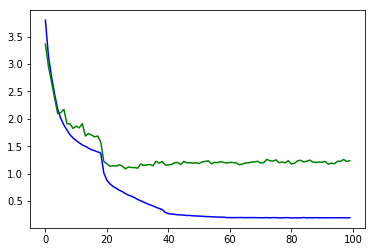

In [30]:
plt.plot(train_loss, label='train', color='b')
plt.plot(valid_loss, label='valid', color='g')

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [0]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [0]:
my_solution = make_solution(resnet, DEVICE)

In [0]:
file_name = 'my_solution_resnet1.csv'

with open(file_name, 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)
        